> Created on Sat Sep 16 10:10:46 2023 @author: Richie Bao-caDesign设计(cadesign.cn)

# 3.9-B 强化学习——Gymnasium 环境构建到深度强化学习（Deep RL）

## 3.9.1 Gymnasium 环境下的 QL 实现

### 3.9.1.1 Gymnasium——强化学习环境 API

[Gymnasium （Gym）库](https://gymnasium.farama.org/content/basic_usage/)<sup>①</sup>是[OpenAI](https://openai.com/)<sup>②</sup>为单个智能体的强化学习环境构建提供的一个应用程序接口（Application Programming Interface，API），除了可以自定义环境外，也提供了常见环境的的实现，例如 cartpole，pendulum， mountain-car， mujoco，atari等。Gym 包含4个关键功能，`make`，`reset`，`step`和`render`；其核心是`Env`，一个高级的 Python 类，代表强化学习理论中马尔可夫决策过程（Markov Decision Processes，MDP）。

> 如果在[Colaborator，CoLab](https://colab.research.google.com/)<sup>③</sup>中书写和运行代码，安装 Gym 时，为了确保使用新安装的库，往往需要重新启动 Jupyter 笔记，并从当前位置继续运行代码，因此可以使用`os.kill(os.getpid(), 9)`方法实现，避免从菜单栏中选择`restart runtime`按钮。

In [ ]:
!pip install gymnasium
!pip install -q swig
!pip install -q gymnasium[box2d]

import os
os.kill(os.getpid(), 9)

In [27]:
%load_ext autoreload 
%autoreload 2 
import usda.rl as usda_rl   

import gymnasium as gym
import numpy as np
import random
from tqdm import tqdm

import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML

from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from gymnasium import spaces
import pygame
from typing import NamedTuple
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1）Gym 的关键功能

使用 Gym 内置的一个环境演示其关键功能，并查看环境属性。Gym 初始化一个环境只需使用`make`函数，这里调用了一个已有环境`FrozenLake-v1`（冰湖），游戏规则是在冰上行走，从起点`(0,0)`到终点`(3，3)`，穿过冰湖而不掉进任何洞里。这里配置了参数`is_slippery=False`，并不考虑冰很滑而使得玩家可能会垂直于预定方向移动。`render_mode`参数提供了渲染环境的模式，Gym 提供了 3 种方式，有`human`，一般以弹窗形式（基于`Pygame`库）连续显示环境状态的变化；`rgb_array`，以数组形式返回当前环境状态的帧，数组形状为 (x,y,3)，包含3个图像通道。通常通过该种形式收集环境状态的帧，然后用`Matplotlib`等库实时更新或者再现环境状态变化的动画；和`ansi`，返回的为字符串（`str`）或者`StringIO.StringIO`，包含每一时刻一个终端样式的文本表示。

初始化环境之后，通过`reset`重置环境，为调用`step`之前所需的初始状态，获得对环境的首次观察（observation）。这里使用`env.action_space.sample()`方法从有效动作空间中随机选取（采样）一个动作，作为参数传入`step`方法，从而智能体在环境中执行该动作，可以理解为移动的机器人或者游戏控制器上的按钮，并导致了环境发生改变。智能体从更新的环境中获得观察结果和所采取动作的收益（奖励）。

`step`的返回值包括：

`observation` (ObsType)，由于智能体动作而观测到的下一个观测值（`observation_space`（观测/状态空间）的一个元素）。对于`FrozenLake-v1`网格环境而言为其单元位置索引整数值；对于`CartPole`则为包含杆`[位置，速度，角度，角速度]`的一个数组；

`reward`（SupportsFloat），作为所采取动作结果的收益/奖励；

`terminated`（bool），是否到达定义为 MDP 任务的最终状态（terminal state），即目标状态（goal state ），如果为`True`，则需要调用`reset`重置环境至初始状态；

`truncated`（bool），是否满足位于 MDP 范围外的截断条件。通常为一个时间限制条件（时刻数），但也可以用来表示智能体在物理上越界，从而在达到目标状态前结束幕（episode）。如果为`True`，则需要调用`reset`重置环境至初始状态；

`info`（dict），包含有助于调试、学习和日志记录的辅助诊断条件，例如，可能包含描述智能体性能状态的指标，隐藏在观测之外的变量，或者组合在一起为总收益（回报）的单个收益值。

下述代码循环了 1000 次，即执行了 1000 步（时刻），如果满足`terminated`或者`truncated`，即完成一幕，则初始化为初始状态后继续执行动作。当执行完所有幕后，调用`clost`关闭环境，尤其使用外部软件时，例如用于渲染的`Pygame`，数据库等。将每一时刻`rgb_array`模式下返回的 RGB 图像数组追加到列表`frames`下，定义`save_frames_as_gif4gym()`函数，将其转化为 GIF 动画保存，结果如下。

In [24]:
def gym_env_steps_rgb_array(gym_env_name,steps=1000,**args):
    # Make gym env
    env = gym.make(gym_env_name, render_mode="rgb_array",**args)
    
    # Run the env
    observation, info = env.reset()
    frames = []
    for t in range(steps):
        # Render to frames buffer
        frames.append(env.render())
        action = env.action_space.sample()
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            observation, info = env.reset()
            
    env.close()
    return frames

frames=gym_env_steps_rgb_array('FrozenLake-v1',steps=1000,is_slippery=False,)
usda_rl.save_frames_as_gif4gym(frames,'../imgs/3_9_b','FrozenLake-v1',figsize_scale=2)

MovieWriter ffmpeg unavailable; using Pillow instead.


<img src="../imgs/3_9_b/FrozenLake-v1_small.gif" height='auto' width=300 title="caDesign">

#### 2）动作和观测（状态）空间（Action and observation spaces）

Gym 的每个环境都使用`env.action_space`和`env.observation_space`指定有效动作和观测（状态）的格式，这有助于了解环境的预期输入和输出，因为所有有效的动作和状态都应该包含在各自的空间中。通过`env.action_space`和`env.observation_space`属性可以查看环境的动作和状态空间值域。例如在`FrozenLake-v1`（冰湖）环境下，动作空间为`Discrete(4)`，包含有4个离散的动作值，其形状为`(1,)`，区间为`{0,3}`，分别表示为：0-向左移动；1-向下移动；2-向右移动；3-向上移动。而状态空间为`Discrete(16)`，表示智能体所处的位置，例如目标状态位置如果为`(3,3)`，可以通过$current row \times nrows+current col$获得其状态值（位置索引），即$3*4+3=15$。一般转换数组位置对应展平序列索引值可以使用`np.ravel_multi_index`方法；如果将展平的序列索引值返回为数组的位置索引则使用`np.unravel_index`方法实现。在`CartPole-v1`（车杆）环境下，动作空间为`Discrete(2)`，包含有2个离散的动作值，其形状为`(1,)`，区间为`{0,1}`，分别表示为：0-将车推向左侧；1-将车推向右侧。而状态空间为`Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)`，是一个形状为`(4,)`的数组，且数值为浮点型，对应的状态值含义和值域如下：

| Num  | Observation （观测/状态） | Min（最小值）  | Max（最大值）  |
|---|---|---|---|
| 0  | Cart Position （车位置） | -4.8 | 4.8  |
| 1  | Cart Velocity （车速度） | -Inf  | Inf  |
| 2  | Pole Angle （杆角度） | ~ -0.418 rad (-24°)  | ~ 0.418 rad (24°) | 
| 3 |  Pole Angular Velocity（杆角速度） | -Inf  |  Inf |


Gym 支持有多种动作和状态空间的类型，如下，

`Box`：描述了一个有界$n$维度的连续空间（continuous space），可以定义上限和下限描述状态的有效值；

`Discrete`：描述了一个离散空间（discrete space），其中$\{0,1, \ldots, n-1\}$为动作、状态的可能值。可以通过可选参数偏移值至$\{a, a+1, \ldots, a+n-1\}$；

`Dict`：以字典形式描述一个简单的空间（simple spaces）；

`Tuple`：以元组形式描述一个简单的空间（simple spaces）；

`MultiBinary`：创建一个形状为$n$的二进制空间（binary space），其参数`n`可以是一个数字或为一个数字列表；

`MultiDiscrete`：由一系列离散的动作空间组成，每一元素下有不同数量的动作。

In [16]:
env_frozenLake=usda_rl.env_info_print('FrozenLake-v1')

Action Space Shape: Discrete(4); Observation Space: Discrete(16)
observation=4
reward=0.0,
terminated=False
truncated= False
info={'prob': 0.3333333333333333}


In [20]:
position_2d=(3,3)
grid_shape=(4,4)
ravel_idx=np.ravel_multi_index(position_2d,grid_shape)
print(ravel_idx)
print(np.unravel_index(ravel_idx,grid_shape))

15
(3, 3)


查看`CartPole-v1`环境。

In [25]:
frames=gym_env_steps_rgb_array('CartPole-v1',steps=1000)
usda_rl.save_frames_as_gif4gym(frames,'../imgs/3_9_b','CartPole-v1',figsize_scale=2)

MovieWriter ffmpeg unavailable; using Pillow instead.


<img src="../imgs/3_9_b/CartPole-v1_small.gif" height='auto' width=300 title="caDesign">

In [17]:
env_frozenLake=usda_rl.env_info_print('CartPole-v1')

Action Space Shape: Discrete(2); Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
observation=[-0.03570371 -0.21809642  0.00349997  0.34255093]
reward=1.0,
terminated=False
truncated= False
info={}


### 3.9.1.2 冰湖上行走的 QL 算法

Gym 的[Frozenlake benchmark](https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto/)<sup>④</sup>提供了冰湖的 QL 代码，为了方便调用将其迁移至`USDA`库。首先定义`Params(NamedTuple)`类用于初始化各类参数如下。其中动作空间大小`action_size`和状态空间大小`state_size`暂未配置，由所用的`FrozenLake-v1`环境属性`env.action_space.n`和`env.observation_space.n`进行更新。

In [100]:
params = usda_rl.Params_frozenlake(
    total_episodes=2000, # Total episodes
    learning_rate=0.8, # Total episodes
    gamma=0.95, # Discounting rate
    epsilon=0.1, # Exploration probability
    map_size=11, # Number of tiles of one side of the squared environment
    seed=123, # Define a seed so that we get reproducible results
    is_slippery=False, # If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions
    n_runs=20, # Number of runs
    action_size=None, # Number of possible actions
    state_size=None, # Number of possible states
    proba_frozen=0.9, # Probability that a tile is frozen
    savefig_folder=None # Root folder where plots are saved
)

# Set the seed
rng = np.random.default_rng(params.seed)

初始化一个冰湖环境，配置网格大小为$11 \times 11$，即状态空间大小为 121；动作空间大小为 4。

In [101]:
env = gym.make(
    "FrozenLake-v1",
    is_slippery=params.is_slippery,
    render_mode="rgb_array",
    desc=generate_random_map(size=params.map_size, p=params.proba_frozen, seed=params.seed),
    )    
       
params = params._replace(action_size=env.action_space.n)
params = params._replace(state_size=env.observation_space.n) 
print(f'action_size={params.action_size}\nstate_size={params.state_size}')

action_size=4
state_size=121


定义`Qlearning`类实现 QL 算法，对算法的具体解释参考*Q 学习：离轨策略下的时序差分控制*部分内容；同时，定义`EpsilonGreedy`类实现$\epsilon$-贪心（$\epsilon-greedy$）策略，决定每一时刻动作的选择。

In [102]:
learner = usda_rl.Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)    

explorer = usda_rl.EpsilonGreedy(
    epsilon=params.epsilon,
    rng=rng
) 

定义`run_env()`函数，传入配置的参数`params`，QL算法类的实例化对象`learner`，动作选择的实例化对象`explorer`和环境`env`，独立运行`params.n_runs`次，即每次运行前均初始化动作价值函数`learner.qtable`（Q-table）为0。每次运行包含执行`params.total_episodes`次幕，每幕包含到达目标状态或提前截断的若干时刻。返回各次每幕的总收益（回报）`rewards`，各次每幕的总时刻数`steps`，执行幕的索引列表`episodes`，各次的动作价值函数估计值（Q-table）`qtables`，所有的状态列表`all_states`和动作列表`all_actions`。

In [103]:
rewards, steps, episodes, qtables, all_states, all_actions = usda_rl.run_env(params,learner,explorer,env) 

考虑到随机性，试验中执行了 20 次，计算各次对应状态价值函数估计值（Q-table）的均值。

In [104]:
qtable = qtables.mean(axis=0) 
print(qtable.shape)
qtable[:5,:]

(121, 4)


array([[0.3584859 , 0.3736744 , 0.36263674, 0.35848592],
       [0.35485969, 0.34663593, 0.24050759, 0.31507437],
       [0.30111175, 0.17550336, 0.12747297, 0.1472572 ],
       [0.14031068, 0.13508486, 0.06562791, 0.09652996],
       [0.06610893, 0.0689629 , 0.0145139 , 0.04880704]])

为了便于用`Seaborn`库打印图表，将试验结果转化为 DataFrame 数据格式，总行数为执行次数 20 和每次幕数 2000 之积，总共40000行。

In [69]:
map_size=params.map_size
res, st = usda_rl.postprocess(episodes, params, rewards, steps, map_size)

`res`结果包括每幕（`Episodes`）的收益`Rewards`，累积收益`cum_rewards`，时刻数（步数）`Steps`。

In [70]:
res

,Episodes,Rewards,Steps,cum_rewards,map_size
0,0,0.0,44.0,0.0,11x11
1,1,0.0,100.0,0.0,11x11
2,2,0.0,27.0,0.0,11x11
3,3,0.0,95.0,0.0,11x11
4,4,0.0,40.0,0.0,11x11
...,...,...,...,...,...
39995,1995,1.0,28.0,151.0,11x11
39996,1996,1.0,24.0,152.0,11x11
39997,1997,0.0,100.0,153.0,11x11
39998,1998,1.0,32.0,154.0,11x11


`st`结果为各次每幕对应时刻数的均值。

In [71]:
st

,Episodes,Steps,map_size
0,0,53.40,11x11
1,1,69.90,11x11
2,2,53.75,11x11
3,3,54.40,11x11
4,4,52.70,11x11
...,...,...,...
1995,1995,24.90,11x11
1996,1996,22.05,11x11
1997,1997,23.60,11x11
1998,1998,21.75,11x11


绘制状态（左图）和动作（右图）出现次数的分布。从状态分布中可以观察到网格单元从上至下，从左至右，越趋近于目标状态的单元格，其出现的次数可能越少。动作分布中，下和右的动作出现的次数多于左和上。

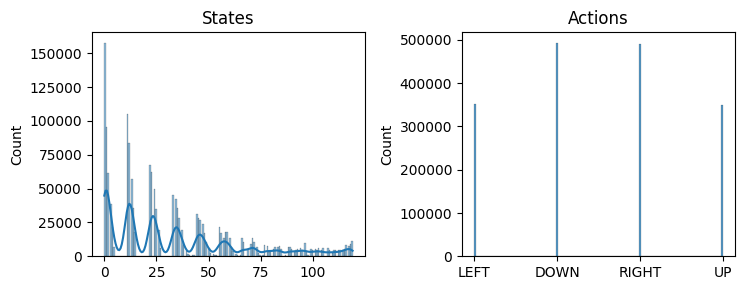

In [72]:
usda_rl.plot_states_actions_distribution(states=all_states, actions=all_actions, map_size=map_size,figsize=(7.55,3))

下左图为绘制模拟的最后一帧，可以看到智能体（小人）出现在目标状态单元格中，表明智能体学会了一个很好的策略来解决此次任务。下右图为智能体学习到的策略（policy），单元格中的每个箭头代表该状态下选择的最优动作。单元格的颜色深浅变化为动作价值函数估计值的最大值（对应最优动作）。

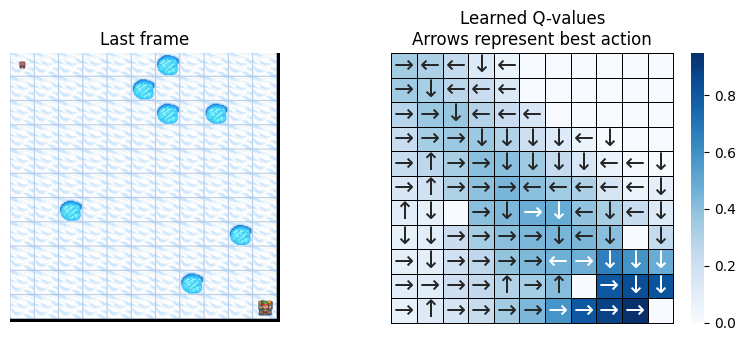

In [73]:
usda_rl.plot_q_values_map(qtable, env, map_size,figsize=(10,3.5))

为了检查智能体是否在学习，绘制每幕对应的累积收益（回报）和每幕结束所用的时刻数。可以观察到随着训练的进行，在约到 800 时刻时，累积收益不断爬升而时刻数开始不断下降，这表明智能体不断学习的成效。

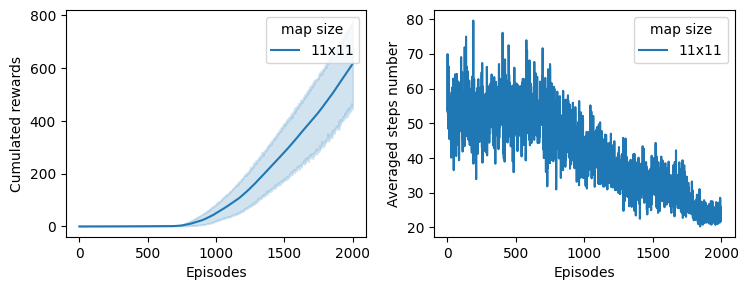

In [94]:
usda_rl.plot_steps_and_rewards(res, st,figsize=(7.6,3))

基于动作价值函数估计值（Q-table）模拟行走的过程路径。从前图最优动作策略状态0和1可以看到，在初始状态0时，动作向右，而在状态1时动作向左，那么如果按照最优动作执行行走，会从状态1返回状态0，并不断在状态0和1之间不断往复，因此在基于 Q-table 模拟休走时，设定如果返回到走过的状态时，则从当前状态下随机选择一个动作而不是选择最优动作。模拟动画结果如下。

In [111]:
anim=usda_rl.show_one_episode_QL(env,qtable,seed=params.seed,n_max_steps=500)
anim.save('../imgs/3_9_b/FrozenLake-v1_11.gif')
HTML(anim.to_jshtml())

<img src="../imgs/3_9_b/FrozenLake-v1_11.gif" height='auto' width=350 title="caDesign">

### 3.9.1.3 构建“在悬崖边上行走”的环境与 QL

直接修改 Gym 库说明文档提供的 [Make your own custom environment](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/)<sup>⑤</sup>代码完成“在悬崖边上行走”的环境构建（其解释参考*强化学习——表格型求解方法*部分）。构建的新环境类继承父类`gym.Env`（`gymnasium.Env`），并初始化网格的高宽数`height`和`width`，及渲染模式`render_mode`。配置状态空间`observation_space`和动作空间`action_space`。同时配置`metadata`，包括支持的渲染模式和每秒帧数（frames per second，fps）`render_fps`。

在`reset`和`step`中需要计算观察值（包括智能体位置`self._agent_location`和目标位置`self._target_location`等），及辅助信息（例如距离等）。为了方便计算，定义私有方法`_get_obs`和`_get_info`，但这不是强制性的，也可以直接在`reset`和`step`中实现。

`reset`方法用于初始化一个新幕。参数`seed`，即随机数生成器（random number generator，RNG）的随机种子可以将幕初始化为一个确定状态。推荐使用由环境基类提供的`self.np_random`方法，但需要调用`super().reset(seed=seed)`以确保`gymnasium.Env`产生正确的 RNG。就“在悬崖边上行走”的环境，配置智能体的初始化状态为`(0,3)`，目标状态为`(11,3)`。

`step`方法通常包含环境的大部分逻辑，接受一个动作`action`，计算应用该动作后环境的新状态并返回包含`observation`、`reward`、`terminated`、`truncated`和`info`的一个元组。一旦获得了环境的新状态，需要检查该状态是否为目标状态（`terminated`），或者被截断（`truncated`），用于后续判断是否结束一幕并调用`reset`初始化一个新幕。

`render`（`_render_frame`）的渲染方式使用了`PyGame`库进行渲染。

`close`方法用于关闭环境打开使用的所有资源。在多数情况下，实际上不用实现这个方法。但是如果渲染模式为`human`，可能需要关闭已经打开的窗口。

In [35]:
class CliffWalkingEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None,height=4,width=12):
        self.height=height # The size of the square grid height
        self.width=width  # The size of the square grid width
        self.window_width=100*width # The size of the PyGame window width
        self.window_height=100*height+1 # The size of the PyGame window height
        self.obstacles=np.array([(x,3) for x in range(1,11)])
     
        self.observation_space=spaces.Discrete(width*height)         
        self.action_space = spaces.Discrete(4) # We have 4 actions, corresponding to "right", "up", "left", "down"

        """
        The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken. I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in human-mode. They will remain `None` until human-mode is used for the first time.
        """
        self.window = None
        self.clock = None

    def _get_obs(self):        
        return {"agent": self._agent_location, "target": self._target_location}

    def _get_info(self):        
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}
        
    def reset(self, seed=None, options=None):        
        super().reset(seed=seed) # We need the following line to seed self.np_random
        self._agent_location=np.array([0,3])
        self._target_location =np.array([11,3])

        observation = np.ravel_multi_index(self._get_obs()['agent'],(self.width,self.height))    
        # observation=self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(self._agent_location + direction, [0,0], [self.width - 1,self.height-1])
        reward = -1 
        
        if self._agent_location.tolist() in self.obstacles.tolist():
            self._agent_location=np.array([0,3])
            reward=-100

        terminated = np.array_equal(self._agent_location, self._target_location) # An episode is done if the agent has reached the target   
        observation = np.ravel_multi_index(self._get_obs()['agent'],(self.width,self.height))
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_width, self.window_height)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_width, self.window_height))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            max(self.window_width,self.window_height)/ max(self.width,self.height)
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.height + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_width, pix_square_size * x),
                width=1,
            )
        for x in range(self.width + 1):    
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_height),
                width=5,
            )
            
        for obstacle in self.obstacles:
            pygame.draw.rect(canvas, (0, 0, 0), pygame.Rect(pix_square_size *obstacle,(pix_square_size, pix_square_size)))

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

实例化自定义的环境，通过从动作空间随机采样查看环境是否正确运行。

In [15]:
cliff_walking_env=CliffWalkingEnv(render_mode="rgb_array")

frames=usda_rl.custom_env_steps_rgb_array(cliff_walking_env,steps=500)
usda_rl.save_frames_as_gif4gym(frames,'../imgs/3_9_b','cliff_walking_env',figsize_scale=2)

MovieWriter ffmpeg unavailable; using Pillow instead.


<img src="../imgs/3_9_b/cliff_walking_env_small.gif" height='auto' width=500 title="caDesign">

后续计算同前文阐述的*冰湖上行走的 QL 算法*。首先用定义的`Params`类初始化参数，并根据环境调整动作空间大小`action_size`和状态空间大小`state_size`。

In [36]:
class Params(NamedTuple):
    total_episodes: int  # Total episodes
    learning_rate: float  # Learning rate
    gamma: float  # Discounting rate
    epsilon: float  # Exploration probability
    n_runs: int  # Number of runs
    action_size: int  # Number of possible actions
    state_size: int  # Number of possible states
    seed: int  # Define a seed so that we get reproducible results
    map_size: int
    
params = Params(
    total_episodes=2000, #2000
    learning_rate=0.8,
    gamma=0.95,
    epsilon=0.1,
    n_runs=5,#20
    action_size=None,
    state_size=None,
    seed=123,
    map_size=[12,4]
    ) 

cliff_walking_env=CliffWalkingEnv(render_mode="rgb_array")
params = params._replace(action_size=cliff_walking_env.action_space.n)
params = params._replace(state_size=cliff_walking_env.observation_space.n)
print(f"Action size: {params.action_size}")
print(f"State size: {params.state_size}")

# Set the seed
rng = np.random.default_rng(params.seed)

Action size: 4
State size: 48


实例化 QL 算法和$\epsilon$-贪心策略。

In [37]:
learner = usda_rl.Qlearning(
    learning_rate=params.learning_rate,
    gamma=params.gamma,
    state_size=params.state_size,
    action_size=params.action_size,
)
explorer = usda_rl.EpsilonGreedy(
    epsilon=params.epsilon,
    rng=rng
)

执行 QL 计算。

In [94]:
rewards, steps, episodes, qtables, all_states, all_actions = usda_rl.run_env(params,learner,explorer,cliff_walking_env) 

In [64]:
map_size=params.map_size
res, st = usda_rl.postprocess(episodes, params, rewards, steps, map_size)

打印动作价值函数估计值的最大值和最优策略。

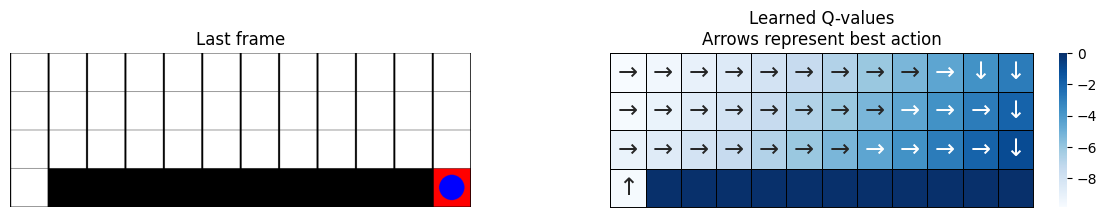

In [95]:
qtable = qtables.mean(axis=0) 
usda_rl.plot_q_values_map(qtable, cliff_walking_env, map_size,figsize=(15, 2),transform=True,directions = {0: "→", 1: "↓", 2: "←", 3: "↑"})

基于动作价值函数估计值（Q-table）模拟行走的过程路径。

In [98]:
anim=usda_rl.show_one_episode_QL(cliff_walking_env,qtable,seed=params.seed)
anim.save('../imgs/3_9_b/cliff_walking_env_ql.gif')
HTML(anim.to_jshtml())

MovieWriter ffmpeg unavailable; using Pillow instead.


<img src="../imgs/3_9_b/cliff_walking_env_ql.gif" height='auto' width=500 title="caDesign">

## 3.9.2 深度 QL（Deep Q-Networks，DQN）<sup>[Stefano V. Albrecht, Filippos Christianos, and Lukas Schäfer. Multi-Agent Reinforcement Learning: Foundations and Modern Approaches. MIT Press, 2023.]161</sup>

### 3.9.2.1 DQN 解析

用 Q-table 表格的形式来表示价值函数，只有遇到某一状态，表格中对应的状态条目的价值估计才会更新，而其它所有状态条目的价值估计值保持不变。因此基于 Q-table 的价值函数无法泛化（generalise），即无法更新与遇到的状态相似但不相同状态的价值估计。且在大型或者连续状态空间问题中，不太可能多次遇到同一状态，因此很难达到精确的估计值。而用神经网络替代 Q-table 表示价值函数，可以泛化到未曾遇到的状态。

2015年，Mnih, V. 等人提出了 deep Q-network（DQN）深度强化学习算法<sup>[1]</sup>。使用`CartPole-v1`（车杆）环境解释 DQN<sup>[2]</sup>。当智能体观测到环境当前状态并选择一个动作时，环境转移到一个新的状态并返回执行该动作后的收益。在这个任务中，每增加一个时刻就获得一个 +1 的收益，而如果杆子掉的太远或者小车偏离中心超过 2.4 个单位，环境转移就会终止。这意味着表现更好的场景是能够运行更长时间并积累更多收益的场景。`CartPole-v1`环境的状态空间包括 0：Cart Position （车位置），1：Cart Velocity （车速度），2：Pole Angle （杆角度）和3：Pole Angular Velocity（杆角速度）；动作空间包括，0：将车推向左侧，1：将车推向右侧。因此，将状态空间的 4 个数值传入（`input`）到一个具有 2 个输出（`output`）的小型全连接网络，输出值对应到动作空间的 2 个动作值。在给定输入状态的情况下，训练网络预测每个动作的期望值，然后选择期望值最大的动作。

同深度学习的一般结构，DQN 需要定义神经网络模型、损失函数和优化器。基于 Q-table 的 QL 算法公式 $Q\left(s^t, a^t\right) \leftarrow Q\left(s^t, a^t\right)+\alpha\left(r^t+\gamma \max _{a^{\prime}} Q\left(s^{t+1}, a^{\prime}\right)-Q\left(s^t, a^t\right)\right)$，智能体以表格形式维护一个动作价值函数$Q$，在时刻$t$，通过在状态$s^t$下执行动作$a^t$，智能体获得一个收益$r^t$，并观测到一个新的状态$s^{t+1}$，进而更新其动作价值函数。根据 QL 算法定义损失函数有，$\mathcal{L}(\theta)=(\underbrace{r^t+\gamma \max _{a^{\prime}} Q\left(s^{t+1}, a^{\prime} ; \theta\right)}_{\text {target value }}-Q\left(s^t, a^t ; \theta\right))^2$，通过更新权值$\theta$，最小化$t$时刻价值函数估计值$Q\left(s^t, a^t ; \theta\right)$和要逼近的自举（bootstrapped）目标价值（由下一时刻$t+1$返回的估计值）$r^t+\gamma \max _{a^{\prime}} Q\left(s^{t+1}, a^{\prime} ; \theta\right)$的平方差（可同时参考*时序差分预测*部分对 TD 误差的解释）。因此，计算关于$\theta$损失的梯度时，反向传播应仅通过$(s^t, a^t)$的价值估计传播，而需要忽略自举的目标价值。

* 移动目标问题

由于智能体的策略在整个训练过程中不断的变化；同时，利用下一状态自举估计计算目标价值估计，这些估计随着价值函数的训练而变化，解决这两个因素引起这的非平稳性问题，称为移动目标问题（ Moving Target Problem）。相比 Q-table，在 DQN 中，更新单个状态的价值估计也会更新所有其它状态的价值估计。为了减少移动目标问题给训练带来的不稳定性，可以给智能体增加一个额外的网络。代码中，`policy_net`表示智能体价值函数的主网络；而`target_net`为增加的带权值的目标网络，两个网络的架构相同，定义如下，

```python
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
```

并且，两个网络使用相同的权值进行初始化。然后，使用目标网络代替主网络来计算损失函数中的自举目标价值，有，$\mathcal{L}(\theta)=(r^t+\gamma \max _{a^{\prime}} \underbrace{Q\left(s^{t+1}, a^{\prime} ; \bar{\theta}\right)}_{\text {target network value }}-\underbrace{Q\left(s^t, a^t ; \theta\right)}_{\text {main network value }})^2$，式中，两个网络的权值分别表示为$\theta$和$\bar{\theta}$。对于目标网络的权值是通过周期性的复制价值函数主网络的权值进行更新，而不是用梯度下降法优化目标网络。这个过程确保自举的目标价值不会离主网络的估计价值太远，但是在一个固定更新次数下保持不变，从而增加目标价值的稳定性。在`PyTorch`提供的 DQN 方法中，对目标网络权值更新给予了调整，使用了$\bar\theta ← \tau \theta + (1 −\tau ) \bar\theta$方法更新，式中$\tau$是目标网络的更新速率（soft update coefficient）。对应代码：

```python
target_net_state_dict = target_net.state_dict()
policy_net_state_dict = policy_net.state_dict()
for key in policy_net_state_dict:
    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
target_net.load_state_dict(target_net_state_dict)
```

* 连续经验的相关性问题

在机器学习的很多范式（paradigms）中，用于训练的数据集通常假设为彼此独立而同分布（independent of each other and identically distributed data，i.i.d. data），这个假设保证训练数据中单个样本间不存在相关性，并所有的数据点均采样于相同的训练分布。而 RL 均违反了 i.i.d 中的两个假设。对于前者，由于将环境形式化为 MDP ，由状态（state）、动作（action）、收益（reward）和下一个状态（next state），即$\left(s^t, a^t, r^t, s^{t+1}\right)$ 4 参数确定的各个单独样本间显然不是独立的，而是高度相关的。时刻$t$的经验（experiences）直接来源于时刻$t+1$，而不是独立于$t+1$的经验。$s^t$和$r^t$由$s^t$和$a^t$为条件的转移函数（transition function）决定。假设从相同的训练分布中采样数据点，RL 中遇到的经验分布取决于当前执行的策略，而策略的更新将引起经验分布的变化。为了解决连续经验的相关性问题，可以随机化用于训练智能体的经验样本，即代替使用连续经验更新价值函数，而是从称为回放缓冲区（replay buffer）$\mathcal{D}$中获取经验样本。为了训练价值函数（主网络），从回放缓冲区中均匀随机抽取一批经验数据$\mathcal{B} \sim \mathcal{D}$用于训练。从$\mathcal{D}$中随机采样的方式使得经验可以多次重复用于训练，提供了样本使用效率；通过批量的经验计算价值损失，而不是单个经验样本，也可以获得更稳定的梯度，以更低的方差进行网络优化。训练过程中，计算每一批次$\mathcal{B}$的均方误差损失并最小化以更新价值函数的权值，有，$\mathcal{L}(\theta)=\frac{1}{\mid B \mid} \sum_{\left(s^t, a^t, r^t, s^{t+1}\right) \in \mathcal{B}}\left(r^t+\gamma \max _{a^{\prime}} Q\left(s^{t+1}, a^{\prime} ; \bar\theta\right)-Q\left(s^t, a^t ; \theta\right)\right)^2, (1)$。定义`ReplayMemory`类构建回放缓冲区，代码如下，

```python
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
```

回放缓冲区可以表示为经验样本的集合$\mathcal{D}=\left\{\left(s^t, a^t, r^t, s^{t+1}\right)\right\}$。通常情况下，回放缓冲区使用固定容量的先入先出队列来实现，当回放缓冲区填满时，旧的经验就会随着新的经验的添加而不断被替换掉。因为缓冲区的经验是在训练过程中使用较早时刻智能体的策略生成，因此这些经验是离轨（off-policy）策略的，只能用于训练离轨策略强化学习算法，这包括 QL 算法。

在`PyTorch`提供的 DQN 方法中为了最小化 TD 误差，用 Huber loss（胡贝尔损失） 代替均方误差作为损失函数，当误差很小时，Huber loss 类似均方误差；但当误差很大时，则类似平均绝对误差，这使得当$Q$的估计非常嘈杂时，它对异常值的鲁棒性更强。如果 TD 误差表示为，$\delta=r^t+\gamma \max _{a^{\prime}} Q\left(s^{t+1}, a^{\prime} ; \bar\theta\right)-Q\left(s^t, a^t ; \theta\right)$，则有$\mathcal{L}=\frac{1}{|B|} \sum_{\left(s^t, a^t, r^t, s^{t+1}\right) \in \mathcal{B}} \mathcal{L}(\delta)$，式中，$\quad \mathcal{L}(\delta)= \begin{cases}\frac{1}{2 \beta} \delta^2 & \text { for }|\delta| \leq 1, \\ |\delta|-\frac{1}{2}\beta & \text { otherwise. }\end{cases}$，式中，$\beta=1$。在`PyTorch`中实现 Huber loss 的方法为[torch.nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html)<sup>⑥</sup>。下述图表中的蓝色曲线为模拟的均方误差结果，而红色曲线为模拟的 Huber loss 计算结果，可以看到 Huber loss 在误差小于等于 1 时保持与均方误差一致；但大于 1 时为平均绝对误差，相对减少了异常值的干扰。

In [3]:
%load_ext autoreload 
%autoreload 2 
import usda.rl as usda_rl  

import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
from itertools import count
from IPython.display import HTML
import numpy as np
import random

from stable_baselines3 import DQN

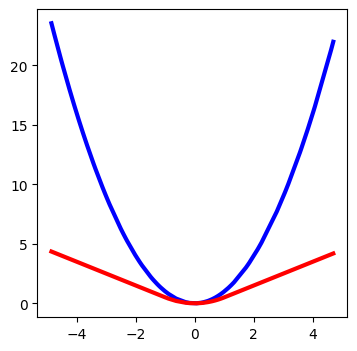

In [41]:
delta_norm=np.sort([-i if random.random()>0.5 else i for i in  np.random.rand(100)*5])

fig, ax=plt.subplots(1, 1,figsize=(4,4))
ax.plot(delta_norm,delta_norm**2,linewidth=3, color='b')
huberloss=[i**2/2 if abs(i)<=1 else abs(i)-0.5 for i in delta_norm]
ax.plot(delta_norm,huberloss,linewidth=3, color='r')

plt.show()

### 3.9.2.2 用 PyTorch 实现 DQN 

根据上述 DQN 算法的解释，求解`CartPole-v1`环境的价值函数，计算过程及结果如下。

In [4]:
env = gym.make("CartPole-v1",render_mode="rgb_array")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [58]:
BATCH_SIZE = 128 # BATCH_SIZE is the number of transitions sampled from the replay buffer
GAMMA = 0.99 # GAMMA is the discount factor as mentioned in the previous section
EPS_START = 0.9 # EPS_START is the starting value of epsilon
EPS_END = 0.05 # EPS_END is the final value of epsilon
EPS_DECAY = 1000 # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005 # TAU is the update rate of the target network
LR = 1e-4 # LR is the learning rate of the ``AdamW`` optimizer
episode_durations = []

n_actions = env.action_space.n # Get number of actions from gym action space
state, info = env.reset()
n_observations = len(state) # Get the number of state observations

policy_net = usda_rl.DQN(n_observations, n_actions).to(device)
target_net = usda_rl.DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = usda_rl.ReplayMemory(10000)
print(n_actions,state,info,n_observations)

2 [-0.02197414  0.04651857  0.04952281 -0.02109905] {} 4


Complete


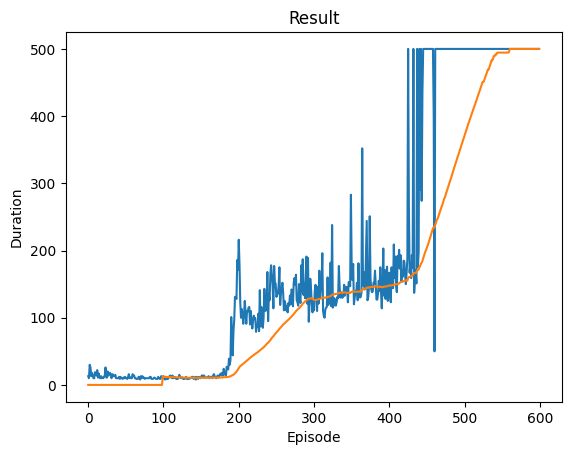

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [65]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = usda_rl.select_action(env,state,policy_net,EPS_START,EPS_END,EPS_DECAY,device)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        # Move to the next state
        state = next_state
        # Perform one step of the optimization (on the policy network)
        usda_rl.optimize_model(policy_net,target_net,optimizer,memory,GAMMA,BATCH_SIZE,device)
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            usda_rl.plot_durations(episode_durations)
            break

print('Complete')
usda_rl.plot_durations(episode_durations,show_result=True)
plt.ioff()
plt.show()

In [68]:
torch.save(policy_net.state_dict(), '../models//CartPole-v1_dqn.pth')

In [67]:
anim=usda_rl.show_one_episode_DQN(env,policy_net,EPS_START,EPS_END,EPS_DECAY,device,n_max_steps=200,figsize=(5, 5))
anim.save('../imgs/3_9_b/CartPole-v1_dqn.gif')
HTML(anim.to_jshtml())

<img src="../imgs/3_9_b/CartPole-v1_dqn.gif" height='auto' width=500 title="caDesign">

### 3.9.2.3 用 stable_baselines3 库的 DQN 直接计算

[Stable Baselines3 (SB3)](https://stable-baselines3.readthedocs.io/en/master/index.html)<sup>⑦</sup>是基于`PyTorch`库强化学习算法的一组可靠实现。SB3 包括的 RL 算法有 Advantage Actor Critic (A2C)，Deep Deterministic Policy Gradient (DDPG)，Deep Q Network (DQN)，Hindsight Experience Replay (HER)，Proximal Policy Optimization algorithm (PPO)，Soft Actor Critic (SAC) 和 Twin Delayed DDPG (TD3) 等。

下述代码直接使用 SB3 库提供的 DQN 计算`CartPole-v1`环境的价值函数。

In [9]:
env = gym.make("CartPole-v1", render_mode="human")

model = DQN("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=100000, log_interval=4)
save_fn="../models/dqn_cartpole.sb3"
model.save(save_fn)
del model # remove to demonstrate saving and loading

调用训练的模型，演示预测结果如下。注意，在训练时配置参数$tau$为默认值1（hard update）。

In [11]:
save_fn="../models/dqn_cartpole.sb3"
env = gym.make("CartPole-v1", render_mode="rgb_array")
model = DQN.load(save_fn)
obs, info = env.reset()
i=1
frames=[]
while True:
    frames.append(env.render())
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated: 
        obs, info = env.reset()
    i+=1
    if i>1000:break   
        
usda_rl.save_frames_as_gif4gym(frames,'../imgs/3_9_b','dqn_cartpole_sb3',figsize_scale=2)

MovieWriter ffmpeg unavailable; using Pillow instead.


<img src="../imgs/3_9_b/dqn_cartpole_sb3_small.gif" height='auto' width=500 title="caDesign">

## 3.9.3 动物的运动及其与土地覆盖类型关系的试验



流动性（mobility）对野生动物的生存至关重要，野生动物的运动（movements）是一种空间现象，其运动特征的建模涉及到位置随时间变化的表征<sup>[3]213</sup>。对动物运动行为的研究已有丰富的成果，例如模拟动物运动的随机漫步模型<sup>[4,5,6]</sup>，考虑景观异质性和多空间尺度影响的运动模型<sup>[7,8,9]</sup>，基于智能体数据驱动的动物运动模型<sup>[10]</sup>等。野生动物运动以获取所需的资源，例如食物、水和栖息地（住所）等。这些驱动机制中，动物的觅食成功与否直接影响到个体的生存、成长和繁殖，及种群动态。在生态学领域已经积累了分析动物觅食行为的丰富研究成果，并开发了描述这种行为的规则和模型<sup>[3]219。

[Movebank](https://www.movebank.org/cms/movebank-main)<sup>⑧</sup>是一个在线动物跟踪数据库，由马克斯·普朗克动物行为研究所（Max Planck Institute of Animal Behavior）托管，帮助动物追踪研究人员管理、共享、保护、分析和存档数据。试验中以[森林公园生活实验室（Forest Park Living Lab，FPL）](https://www.movebank.org/cms/webapp?gwt_fragment=page=studies,path=study1605024900)<sup>⑨</sup>动物运动跟踪数据为样本试验，该数据集所属项目的目标是更好的了解城市食物网中生物多样性运动，包括宿主（hosts ）和病原体（pathogens），并向学生和更广泛的社区公众传递生物多样性的价值，改善城市生物多样性的管理等。

动物的运动及其与土地覆盖类型关系的试验包括前后关联的两个部分，第一部分试图建立土地覆盖类型（landcover，LC）和反应动物活动强度的动物运动点核密度估计（kernel density estimator，KDE）之间的机器学习预测模型；第二部分试图用预测模型作为智能体动作收益模型，根据 LC，寻找给定出发地和目的地的最优运动路径，评估建立连接生物运动廊道的可能区域。

In [182]:
%load_ext autoreload 
%autoreload 2 
import usda.datasets as usda_datasets
import usda.data_visual as usda_datavisual
import usda.geodata_process_opt as usda_geoprocess_opt
import usda.utils as usda_utils
import usda.rl as usda_rl 

import pystac_client
import planetary_computer
import glob
import os
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import geopandas as gpd
import pandas as pd
from scipy import stats
import numpy as np
import fiona
import rasterio as rst
from tqdm import tqdm
import pickle

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
  
import gymnasium as gym
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
from gymnasium import spaces
import pygame

from stable_baselines3 import DQN,PPO

pd.options.mode.chained_assignment = None 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 3.9.3.1 数据准备

#### 1）下载 ESA WorldCover LC 数据

欧空局（European Space Agency，ESA）基于 Sentinel-1 和 2 发布的 10 m高空分辨率 2020 和 2021 年全球土地覆盖产品（WorldCover）的具体阐述可以查看*ESA WorldCover（LULC） 数据下载*部分。前文数据获取仅下载了给定区域范围内的瓦片数据，此次从[ESA WorldCover 2021](https://worldcover2021.esa.int/downloader)<sup>⑩</sup>一次性下载全球所有数据，文件大小为 18.2 G，总共包含有 324 个瓦片。为了从众多瓦片中找到研究区域对应的 LC 数据，仍然采用定义的`esa_worldcover_downloading()`方法，根据指定的研究区域获得对应的瓦片格网 ID 索引，从对对应找到研究区域 LC 数据。

In [9]:
St_Louis_bounds=(-91.059618,38.266734,-88.918609, 39.405234)
save_root=r'D:\data_B\St_Louis_city'

url_lst,fns,tiles=usda_datasets.esa_worldcover_downloading(St_Louis_bounds,save_root,y='2020')
print(url_lst)

100%|███████████████████████████████████████████████████| 4/4 [01:54<00:00, 28.58s/it]

['https://esa-worldcover.s3.eu-central-1.amazonaws.com/v100/2020/map/ESA_WorldCover_10m_2020_v100_N36W090_Map.tif', 'https://esa-worldcover.s3.eu-central-1.amazonaws.com/v100/2020/map/ESA_WorldCover_10m_2020_v100_N39W090_Map.tif', 'https://esa-worldcover.s3.eu-central-1.amazonaws.com/v100/2020/map/ESA_WorldCover_10m_2020_v100_N39W093_Map.tif', 'https://esa-worldcover.s3.eu-central-1.amazonaws.com/v100/2020/map/ESA_WorldCover_10m_2020_v100_N36W093_Map.tif']


In [32]:
St_Louis_city_esa_worldcover_id=tiles.ll_tile.tolist()
St_Louis_city_esa_worldcover_id

['N36W090', 'N39W090', 'N39W093', 'N36W093']

通过定义的`worldcover_cmap4plot()`方法返回 LC 分类图例`cmap`，用于分类地图打印。

In [5]:
cmap,values,boundaries,ticks,tick_labels=usda_datavisual.worldcover_cmap4plot()

C:\Users\richie\anaconda3\envs\RL\Lib\site-packages\pystac_client\item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


从下载的 ESA WorldCover LC 数据文件中提取研究区域文件路径名。

In [2]:
St_Louis_esa_path=r'C:\Users\richie\omen_richiebao\omen_data_temp\ESA_WorldCover_10m_2021_v200_60deg_macrotile_N30W120'
St_Louis_city_esa_worldcover_id=['N36W090', 'N39W090', 'N39W093', 'N36W093']
St_Louis_esa_fns=[i for i in glob.glob(os.path.join(St_Louis_esa_path,'*.tif')) if i.split('_')[-2] in St_Louis_city_esa_worldcover_id]
St_Louis_esa_fns

['C:\\Users\\richie\\omen_richiebao\\omen_data_temp\\ESA_WorldCover_10m_2021_v200_60deg_macrotile_N30W120\\ESA_WorldCover_10m_2021_V200_N36W090_Map.tif',
 'C:\\Users\\richie\\omen_richiebao\\omen_data_temp\\ESA_WorldCover_10m_2021_v200_60deg_macrotile_N30W120\\ESA_WorldCover_10m_2021_V200_N36W093_Map.tif',
 'C:\\Users\\richie\\omen_richiebao\\omen_data_temp\\ESA_WorldCover_10m_2021_v200_60deg_macrotile_N30W120\\ESA_WorldCover_10m_2021_V200_N39W090_Map.tif',
 'C:\\Users\\richie\\omen_richiebao\\omen_data_temp\\ESA_WorldCover_10m_2021_v200_60deg_macrotile_N30W120\\ESA_WorldCover_10m_2021_V200_N39W093_Map.tif']

使用定义的`raster_mosaic()`方法合并研究区域的 4 个瓦片数据。

In [4]:
St_Louis_esa_fn=r'C:\Users\richie\omen_richiebao\omen_data_temp\st_louis_esa_mosaic.tif'
usda_geoprocess_opt.raster_mosaic(r'C:\Users\richie\omen_richiebao\omen_data_temp\st_louis_esa',St_Louis_esa_fn)

Affine(8.333333333333333e-05, 0.0, -93.0,
       0.0, -8.333333333333333e-05, 42.0)

读取合并的 LC 数据，并查看投影信息。

In [38]:
St_Louis_esa=rxr.open_rasterio(St_Louis_esa_fn,masked=True).squeeze()
print(St_Louis_esa.rio.crs)

EPSG:4326


#### 2）从 Movebank 下载动物运动跟踪数据

以森林公园生活实验室动物运动跟踪数据为样本试验，该数据集提供有多种下载数据格式，试验中下载的为 CSV 格式数据。读取查看一行下载的数据如下，其中包括`individual-taxon-canonical-name`动物分类学名称，`tag-local-identifier`标识，`location-long`经度，`location-long`维度，`timestamp`时间戳等关键信息，以及环境温度和运动等相关信息。

In [31]:
forest_park_living_lab_data_fn=r'D:\data_B\movebank\Forest Park Living Lab.csv'
forest_park_living_lab_data=pd.read_csv(forest_park_living_lab_data_fn)

C:\Users\richie\AppData\Local\Temp\ipykernel_30032\2180108370.py:2: DtypeWarning: Columns (9,11,20,36,47,55) have mixed types. Specify dtype option on import or set low_memory=False.
  forest_park_living_lab_data=pd.read_csv(forest_park_living_lab_data_fn)


In [40]:
forest_park_living_lab_data.iloc[0]

event-id                                                     19257107578
visible                                                             True
timestamp                                        2021-07-06 14:00:20.000
location-long                                                 -90.297824
location-lat                                                   38.636373
gps:activity-count                                                   NaN
bar:barometric-pressure                                              0.0
ctt:solar-current-since-last-fix                                     NaN
data-decoding-software                                              13.0
eobs:acceleration-axes                                               NaN
eobs:acceleration-sampling-frequency-per-axis                        NaN
eobs:accelerations-raw                                               NaN
eobs:activity                                                        NaN
eobs:activity-samples                              

为了避免多种信息干扰，仅提取了部分关键信息字段，并转化为包含地理信息的 `GeoDataFrame` 数据格式，保持至本地磁盘。

In [41]:
columns_selection=['event-id', 'visible', 'timestamp', 'location-long', 'location-lat','eobs:temperature','ground-speed', 'heading', 'height-above-ellipsoid',
                   'individual-taxon-canonical-name', 'tag-local-identifier','individual-local-identifier', 'study-name', 'utm-easting','utm-northing', 'utm-zone']

forest_park_living_lab_data_sel=forest_park_living_lab_data[columns_selection]
forest_park_living_lab_data_sel_gdf=gpd.GeoDataFrame(forest_park_living_lab_data_sel,geometry=gpd.points_from_xy(forest_park_living_lab_data_sel['location-long'],forest_park_living_lab_data_sel['location-lat'],crs="EPSG:4326"))

In [42]:
forest_park_living_lab_data_sel_gdf.head(2)

,event-id,visible,timestamp,location-long,location-lat,eobs:temperature,ground-speed,heading,height-above-ellipsoid,individual-taxon-canonical-name,tag-local-identifier,individual-local-identifier,study-name,utm-easting,utm-northing,utm-zone,geometry
0,19257107578,True,2021-07-06 14:00:20.000,-90.297824,38.636373,28.0,0.06,20.32,132.5,Procyon lotor,8374,Jonathan,Forest Park Living Lab,735198.488351,4.279890e+06,15N,POINT (-90.29782 38.63637)
1,19257107579,True,2021-07-06 15:00:14.000,-90.297516,38.636390,28.0,0.04,0.00,145.3,Procyon lotor,8374,Jonathan,Forest Park Living Lab,735225.192388,4.279893e+06,15N,POINT (-90.29752 38.63639)


In [45]:
forest_park_living_lab_data_sel_fn=r'D:\data_B\movebank\forest_park_living_lab_data_sel.gpkg'
forest_park_living_lab_data_sel_gdf.to_file(forest_park_living_lab_data_sel_fn,driver='GPKG', layer='fpll')

读取保存的动物运动跟踪数据。

In [3]:
forest_park_living_lab_data_sel_fn=r'D:\data_B\movebank\forest_park_living_lab_data_sel.gpkg'
forest_park_living_lab_data_sel_gdf=gpd.read_file(forest_park_living_lab_data_sel_fn)

从数据的动物名称列可知跟踪的动物有，


| Procyon lotor（浣熊）  |  Bubo virginianus（美洲雕鸮） | Anas platyrhynchos（绿头鸭）  | Buteo jamaicensis（红尾鵟）  | Branta canadensis（加拿大黑雁）  | Chelydra serpentina（鳄龟） |
|---|---|---|---|---|---|
| <img src="../imgs/3_9_b/3_9_b_04.jpg" height=300 width=300 title="caDesign">  | <img src="../imgs/3_9_b/3_9_b_05.jpg" height=300 width=300 title="caDesign">   |  <img src="../imgs/3_9_b/3_9_b_06.jpg" height=300 width=300 title="caDesign"> | <img src="../imgs/3_9_b/3_9_b_07.jpg" height=300 width=300 title="caDesign">  |  <img src="../imgs/3_9_b/3_9_b_08.jpg" height=300 width=300 title="caDesign"> |   <img src="../imgs/3_9_b/3_9_b_09.jpg" height=300 width=300 title="caDesign">  |

> 图片来源于 Google 搜索结果。


将所有动物的运动跟踪数据叠合打印到 ESA WorldCover LC 数据上，查看动物运动的范围与城市的关系。

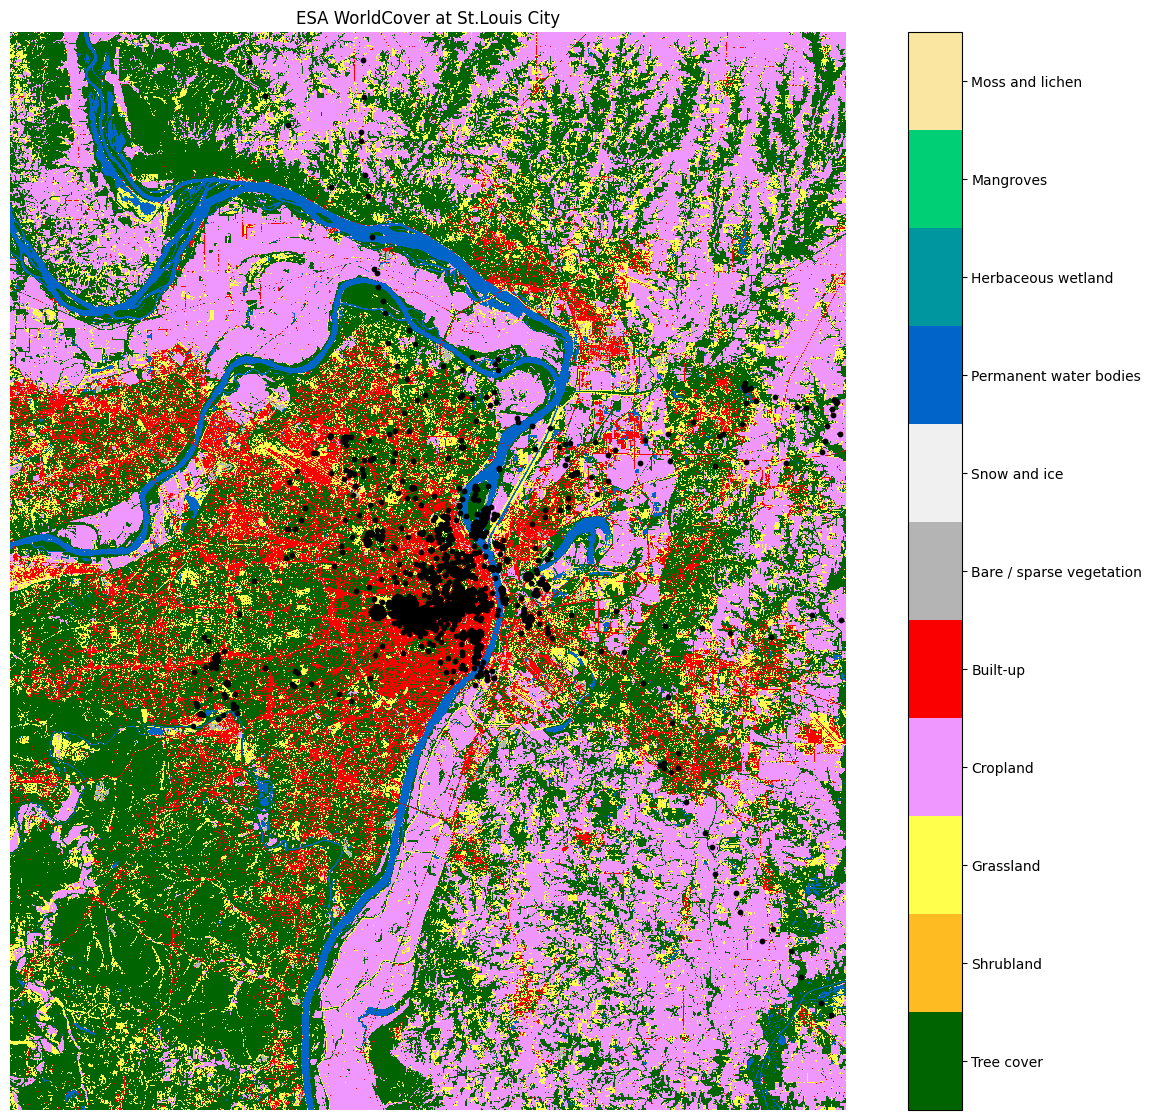

In [44]:
fig, ax = plt.subplots(figsize=(16, 14))
normalizer = matplotlib.colors.Normalize(vmin=0, vmax=255)

x_0=28000
y_0=35000
delta=10000
St_Louis_esa.isel(y=slice(y_0, y_0+delta), x=slice(x_0,x_0+delta)).plot(ax=ax, cmap=cmap, norm=normalizer)
forest_park_living_lab_data_sel_gdf.plot(color='k',markersize=10,ax=ax)

colorbar=fig.colorbar(
    cm.ScalarMappable(norm=normalizer, cmap=cmap),
    boundaries=boundaries,
    values=values,
    cax=fig.axes[1].axes,
)
colorbar.set_ticks(ticks, labels=tick_labels)

ax.set_axis_off()
ax.set_title("ESA WorldCover at St.Louis City");

为了更清晰的查看不同动物的运动跟踪数据，在 QGIS 中叠合打印地图，可以观察到 Buteo jamaicensis 运动范围最广，并有两条明显的远途运动轨迹；Branta canadensis 则集中活动于全城有水域的区域；Bubo virginianus 主要在圣路易（St.Louis
森林公园东部活动（Forest Park）；Anas platyrhynchos 活动于森林公园的水域区域；Procyon lotor 活动于森林公园西南部森林区域；而Chelydra serpentina活动范围最小，仅在森林公园小部分水域中活动。）

In [47]:
forest_park_living_lab_data_sel_gdf['individual-taxon-canonical-name'].unique() 

array(['Procyon lotor', 'Bubo virginianus', 'Anas platyrhynchos',
       'Buteo jamaicensis', 'Branta canadensis', 'Chelydra serpentina'],
      dtype=object)

<img src="../imgs/3_9_b/3_9_b_01.png" height='auto' width='auto' title="caDesign">

本次试验仅选择了Procyon lotor（浣熊）运动跟踪轨迹为试验对象，从叠合地图中可以观察到浣熊的主要活动区域，以森林公园西南部的森林为主要获得范围，偶尔跨过道路进入到居住区部分的林地。

In [5]:
procyon_lotor_gdf=forest_park_living_lab_data_sel_gdf[forest_park_living_lab_data_sel_gdf['individual-taxon-canonical-name']=='Procyon lotor']
procyon_lotor_gdf.dropna(subset=['location-long'],inplace=True)
print(procyon_lotor_gdf.shape)

(4865, 17)


<img src="../imgs/3_9_b/3_9_b_02_2.png" height='auto' width=700 title="caDesign">

将浣熊的运动跟踪轨迹数据导出为 KML 数据，在 Google Earth 中加载，观察运动轨迹与环境的关系。

In [84]:
fiona.supported_drivers['KML'] = 'rw'
fiona.supported_drivers

{'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'raw',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'raw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'raw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r',
 'KML': 'rw'}

In [82]:
procyon_lotor_fn=r'D:\data_B\movebank\procyon_lotor.kml'
procyon_lotor_gdf.to_file(procyon_lotor_fn,driver='KML')

<img src="../imgs/3_9_b/3_9_b_03_small.jpg" height='auto' width='auto' title="caDesign">

计算浣熊运动跟踪轨迹核密度（KDE），观察活动区域的强度。一定程度上，活动越多的区域表明为浣熊越易于栖居的地方；而活动强度越少的地方，可能仅是试探性的“探险”。

In [101]:
coordinates=np.array([procyon_lotor_gdf.geometry.x,procyon_lotor_gdf.geometry.y])
kde=stats.gaussian_kde(coordinates)
procyon_lotor_gdf['kde']=kde(coordinates)

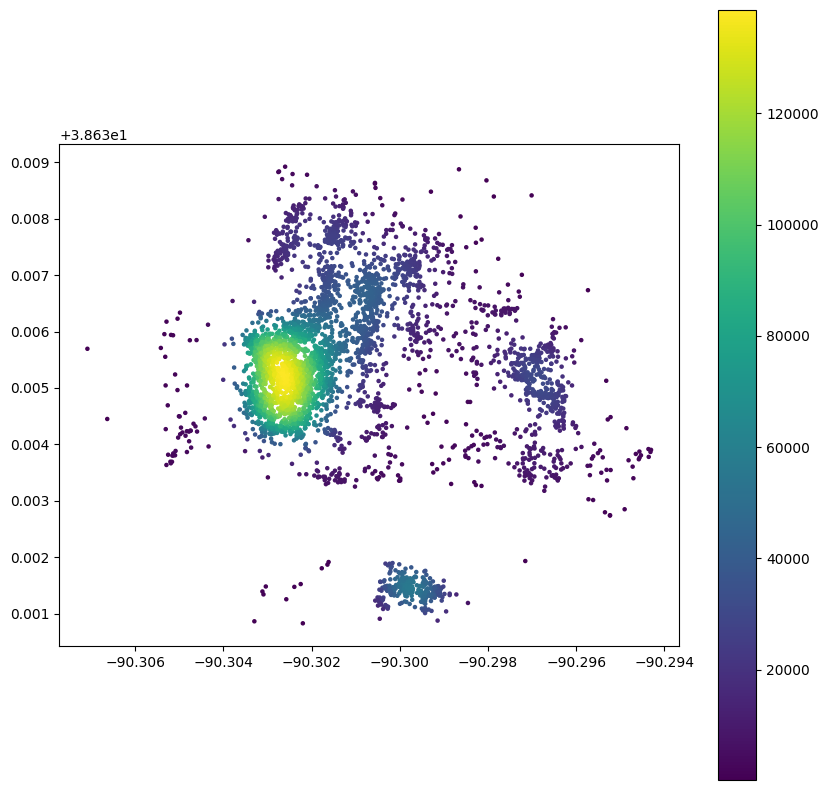

In [89]:
procyon_lotor_gdf.plot(column='kde',markersize=5,legend=True,figsize=(10,10));

#### 3）1m LC 数据获取

10m 高空分辨率的 ESA WorldCover LC 数据相对于浣熊小范围的运动跟踪轨迹来说，其高空分辨率相对较低，因此从[St. Louis Regional Data Exchange](https://rdx.stldata.org/dataset/land-cover/resource/8f5def62-3da3-436a-be63-e277ce33d2ed)<sup>⑪</sup>下载2017年 1m 高空分辨率的 LC 数据用于试验计算。该 LC 数据来源于密苏里大学（University of Missouri ）自然资源学院，总共分为7类，解释如下，

1. Urban/Impervious（城市/不透水），例如屋顶、铺砌的道路和地块等；
2. Open Water（开放水域）；
3. Row Crops（作物），所选择解译的两个日期的影像中未休耕的农田；
4. Grassland（草原），包括草地、羊茅地（fescue fields）和牧草为主的地区；
5. Evergreen Woody Vegetation（常绿木本植被），例如东方红衫（ eastern redcedar）、人工松林等；
6. Deciduous Woody Vegetation（落叶木本植被），例如橡树、榆树、白蜡树和杨树等；
7. Barren/Sparsely Vegetated（裸地/稀疏的植被），例如未铺设的土地、新开发的土地和休耕的农田等。

叠加打印 1m LC 数据和浣熊运动跟踪轨迹点如下。并统一投影。

In [2]:
LC4procyon_lotor_fn=r'C:\Users\richie\omen_richiebao\omen_data_temp\st_louis_1m.tif'

LC4procyon_lotor=rxr.open_rasterio(LC4procyon_lotor_fn,masked=True).squeeze()
print(LC4procyon_lotor.rio.crs,'\n',LC4procyon_lotor.shape)

EPSG:26915 
 (2716, 2608)


In [103]:
procyon_lotor_prj_gdf=procyon_lotor_gdf.copy(deep=True).to_crs(LC4procyon_lotor.rio.crs)
procyon_lotor_prj_fn=r'D:\data_B\movebank\procyon_lotor_prj.gpkg'
procyon_lotor_prj_gdf.to_file(procyon_lotor_prj_fn,driver='GPKG', layer='fpll')

In [13]:
levels = list(range(1,8))
clrs = ['#000000','#005ce6', '#3f8f76', '#ffffbe', '#3a5b0d', '#aaff00', '#e1e1e1']    
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, clrs,extend='max')

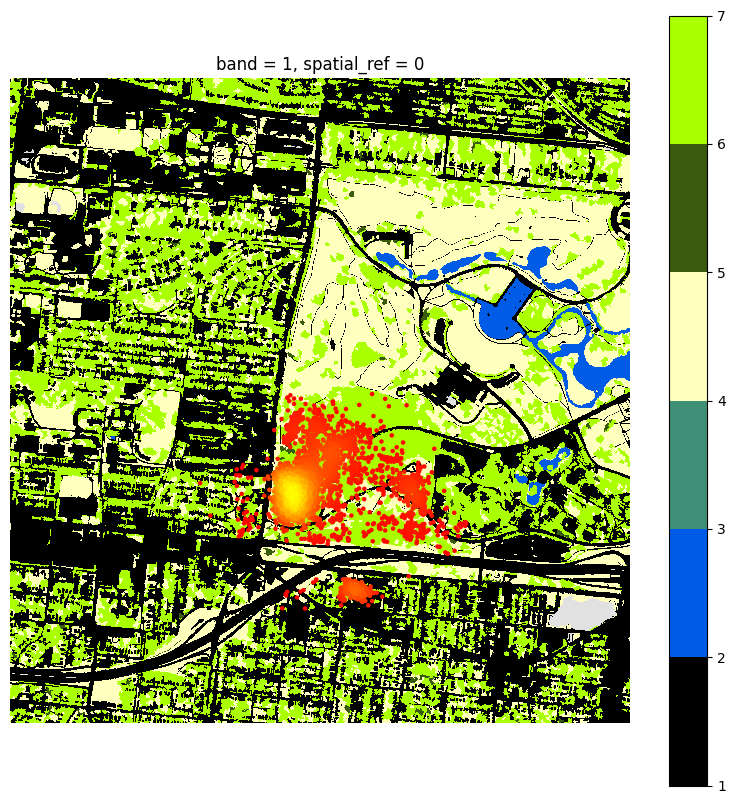

In [65]:
fig, ax=plt.subplots(figsize=(10, 10))
LC4procyon_lotor.plot(ax=ax,cmap=cmap,norm=norm)
procyon_lotor_prj_gdf.plot(column='kde',markersize=5,ax=ax,cmap='autumn')

ax.set_axis_off()
plt.show()

### 3.9.3.2 建立 LC 和活动强度的预测模型

以浣熊运动跟踪轨迹各个样本点到邻域 LC 各类型单元距离的倒数和作为解释变量（反应了样本点邻域 LC 类型数量和距离观测样本点距离之间的关系），以对应的 KDE 值为目标变量，使用`Sklearn`库的 Ordinary Least Squares（最小二乘法）建立预测模型。

#### 1）基于 1m LC 的分析

In [6]:
procyon_lotor_prj_fn=r'D:\data_B\movebank\procyon_lotor_prj.gpkg'
procyon_lotor_prj_gdf=gpd.read_file(procyon_lotor_prj_fn)

LC4procyon_lotor_fn=r'C:\Users\richie\omen_richiebao\omen_data_temp\st_louis_1m.tif'
LC4procyon_lotor_rst=rst.open(LC4procyon_lotor_fn)
procyon_lotor_prj_vals=LC4procyon_lotor_rst.read(1)
procyon_lotor_prj_vals.shape

(2716, 2608)

根据样本点的经纬度坐标提取 LC 栅格数据对应栅格单元的网格位置索引坐标。

In [22]:
procyon_lotor_prj_coordinates=np.array([procyon_lotor_prj_gdf.geometry.x,procyon_lotor_prj_gdf.geometry.y]).T
row_col=np.array([LC4procyon_lotor_rst.index(coordi[0],coordi[1]) for coordi in procyon_lotor_prj_coordinates]) # [y(row),x(col)]

为了确定距离对运动跟踪轨迹样本点的影响，即通过比较不同邻域大小预测 KDE 的精度，估计 LC 对浣熊活动影响的最优距离。从下述计算结果可以发现，随着距离的增加预测精度不断提升，到达约 450m （1m LC 栅格数据栅格单元大小为$1 \times 1m$）距离后达到最大值，如果距离再增加而预测精度不再提升，并有所下降，且上下波动。

In [589]:
r_LinearRegression_r2score={}
for r in tqdm(range(50,1000+50,50)):
    group_sum_dict_lst=[]
    for row,col in row_col:    
        nbr_xy=usda_utils.grid_neighbors(procyon_lotor_prj_vals,row,col,r=r)
        nbr_dist=usda_utils.grid_distance(nbr_xy,row,col)
        group_sum_dict=usda_utils.group_sum(procyon_lotor_prj_vals,nbr_xy,1/nbr_dist)  
        group_sum_dict_lst.append(group_sum_dict)

    group_sum_df=pd.DataFrame.from_records(group_sum_dict_lst).fillna(0)
    X=group_sum_df.to_numpy()
    y=procyon_lotor_prj_gdf.kde.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3) 
    reg = linear_model.LinearRegression()
    reg.fit(X_train,y_train)
    
    y_pred=reg.predict(X_test)
    r2Score=r2_score(y_test, y_pred)
    r_LinearRegression_r2score[r]=r2Score

100%|██████████████████████████████████████████████| 20/20 [4:32:39<00:00, 818.00s/it]


保存计算结果至本地磁盘。

In [ ]:
r_LinearRegression_r2score_fn=r'../data/r_LinearRegression_r2score.pickle'
with open(r_LinearRegression_r2score_fn,'wb') as f:
   pickle.dump(r_LinearRegression_r2score,f)

In [590]:
r_LinearRegression_r2score

{50: 0.2969262447199512,
 100: 0.33550466278417246,
 150: 0.3610393650898759,
 200: 0.4652860554178667,
 250: 0.5894252433611351,
 300: 0.5488655636130021,
 350: 0.6055035152885337,
 400: 0.682679448168465,
 450: 0.7178165774907387,
 500: 0.696234080034751,
 550: 0.641514129775351,
 600: 0.6333216449150836,
 650: 0.6221094384801411,
 700: 0.604849372184669,
 750: 0.628702941020405,
 800: 0.6287903434818601,
 850: 0.6429952572242148,
 900: 0.6720577340368685,
 950: 0.6851036119760447,
 1000: 0.6712013628226081}

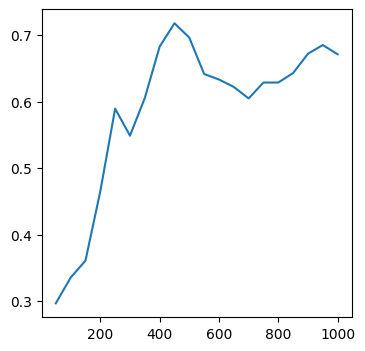

In [604]:
fig, ax=plt.subplots(1, 1,figsize=(4,4))
ax.plot(r_LinearRegression_r2score.keys(),r_LinearRegression_r2score.values())
plt.show()

根据上述计算结果分析，选择最优距离 450m 训练预测模型，并保存方便后续调用。

In [4]:
r=450
group_sum_dict_lst=[]
for row,col in tqdm(row_col):    
    nbr_xy=usda_utils.grid_neighbors(procyon_lotor_prj_vals,row,col,r=r)
    nbr_dist=usda_utils.grid_distance(nbr_xy,row,col)
    group_sum_dict=usda_utils.group_sum(procyon_lotor_prj_vals,nbr_xy,1/nbr_dist)  
    group_sum_dict_lst.append(group_sum_dict)

100%|█████████████████████████████████████████████| 4865/4865 [09:06<00:00,  8.90it/s]


给定距离内，样本点到邻域 LC 类型单元距离的倒数和计算结果如下。从计算结果得知，包括的 LC 类型为 1（城市不透水区域）、2（开放水体）、4（草地）、5（常绿木本植被）、6（落叶木本植被）和7（地/稀疏的植被）等 6 类。

In [5]:
group_sum_df=pd.DataFrame.from_records(group_sum_dict_lst).fillna(0)
group_sum_df.tail(3)

,1,4,5,6,7,2
4862,1196.182730,497.214999,20.386790,1429.197140,8.38746,21.201547
4863,708.999460,705.072211,25.256320,1733.242675,0.00000,0.000000
4864,665.906418,858.525840,15.845081,1632.293328,0.00000,0.000000


建立训练和测试数据集。

In [6]:
X=group_sum_df.to_numpy()
y=procyon_lotor_prj_gdf.kde.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3) 

训练机器学习模型。模型的预测精度约为 0.712。

In [7]:
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)

y_pred=reg.predict(X_test)
r2_score(y_test, y_pred)

0.7127264417436792

保存训练好的机器学习模型至本地磁盘。

In [8]:
procyon_lotor_LinearRegression_450_fn=r'../models/procyon_lotor_LinearRegression_450.pickle'
with open(procyon_lotor_LinearRegression_450_fn,'wb') as f:
    pickle.dump(reg,f)

定义`predicting_kde()`函数，应用训练的预测模型批量计算给定索引坐标的 KDE 值。为了减少计算量，配置`interval=100`参数，间隔提取用于预测的索引坐标；同时，使用多线程计算。该函数返回的值为一个包含`(idx_row,idx_col,kde)`的列表。

In [ ]:
predicted_kde=usda_rl.predicting_kde(model,procyon_lotor_prj_vals,r=450,ratio_cpu=0.8,interval=100)

predicted_kde_fn=r'C:\Users\richie\omen_richiebao\omen_github\USDA_special_study\data\predicted_kde.pickle'    
with open(predicted_kde_fn,'wb') as f:
    pickle.dump(predicted_kde,f)

In [44]:
predicted_kde_fn=r'C:\Users\richie\omen_richiebao\omen_github\USDA_special_study\data\predicted_kde.pickle'   
with open(predicted_kde_fn,'rb') as f:
    predicted_kde=pickle.load(f)

提取行列索引和对应的 KDE 值。并设置了一个`scale`参数用于缩放 KDE 值为一个较小的值。

In [79]:
rows,cols,kdes=map(list,zip(*predicted_kde))
scale=20000

因为训练模型时，配置了距离参数为 450m，因此剔除了小于该距离的边界区域。通过对小于该距离边界点的采样计算，发现预测的值极大或极小，预测的值明显不正确。

从下述计算结果打印的地图可以发现，通常具有较多成片树木覆盖的区域是浣熊可能会（经常）出没的地方，其 KDE 相对较大；而东北部的高尔夫球场，KDE 通常为负值，其树木稀疏且分散，不能够为浣熊提供有效的“掩护”。

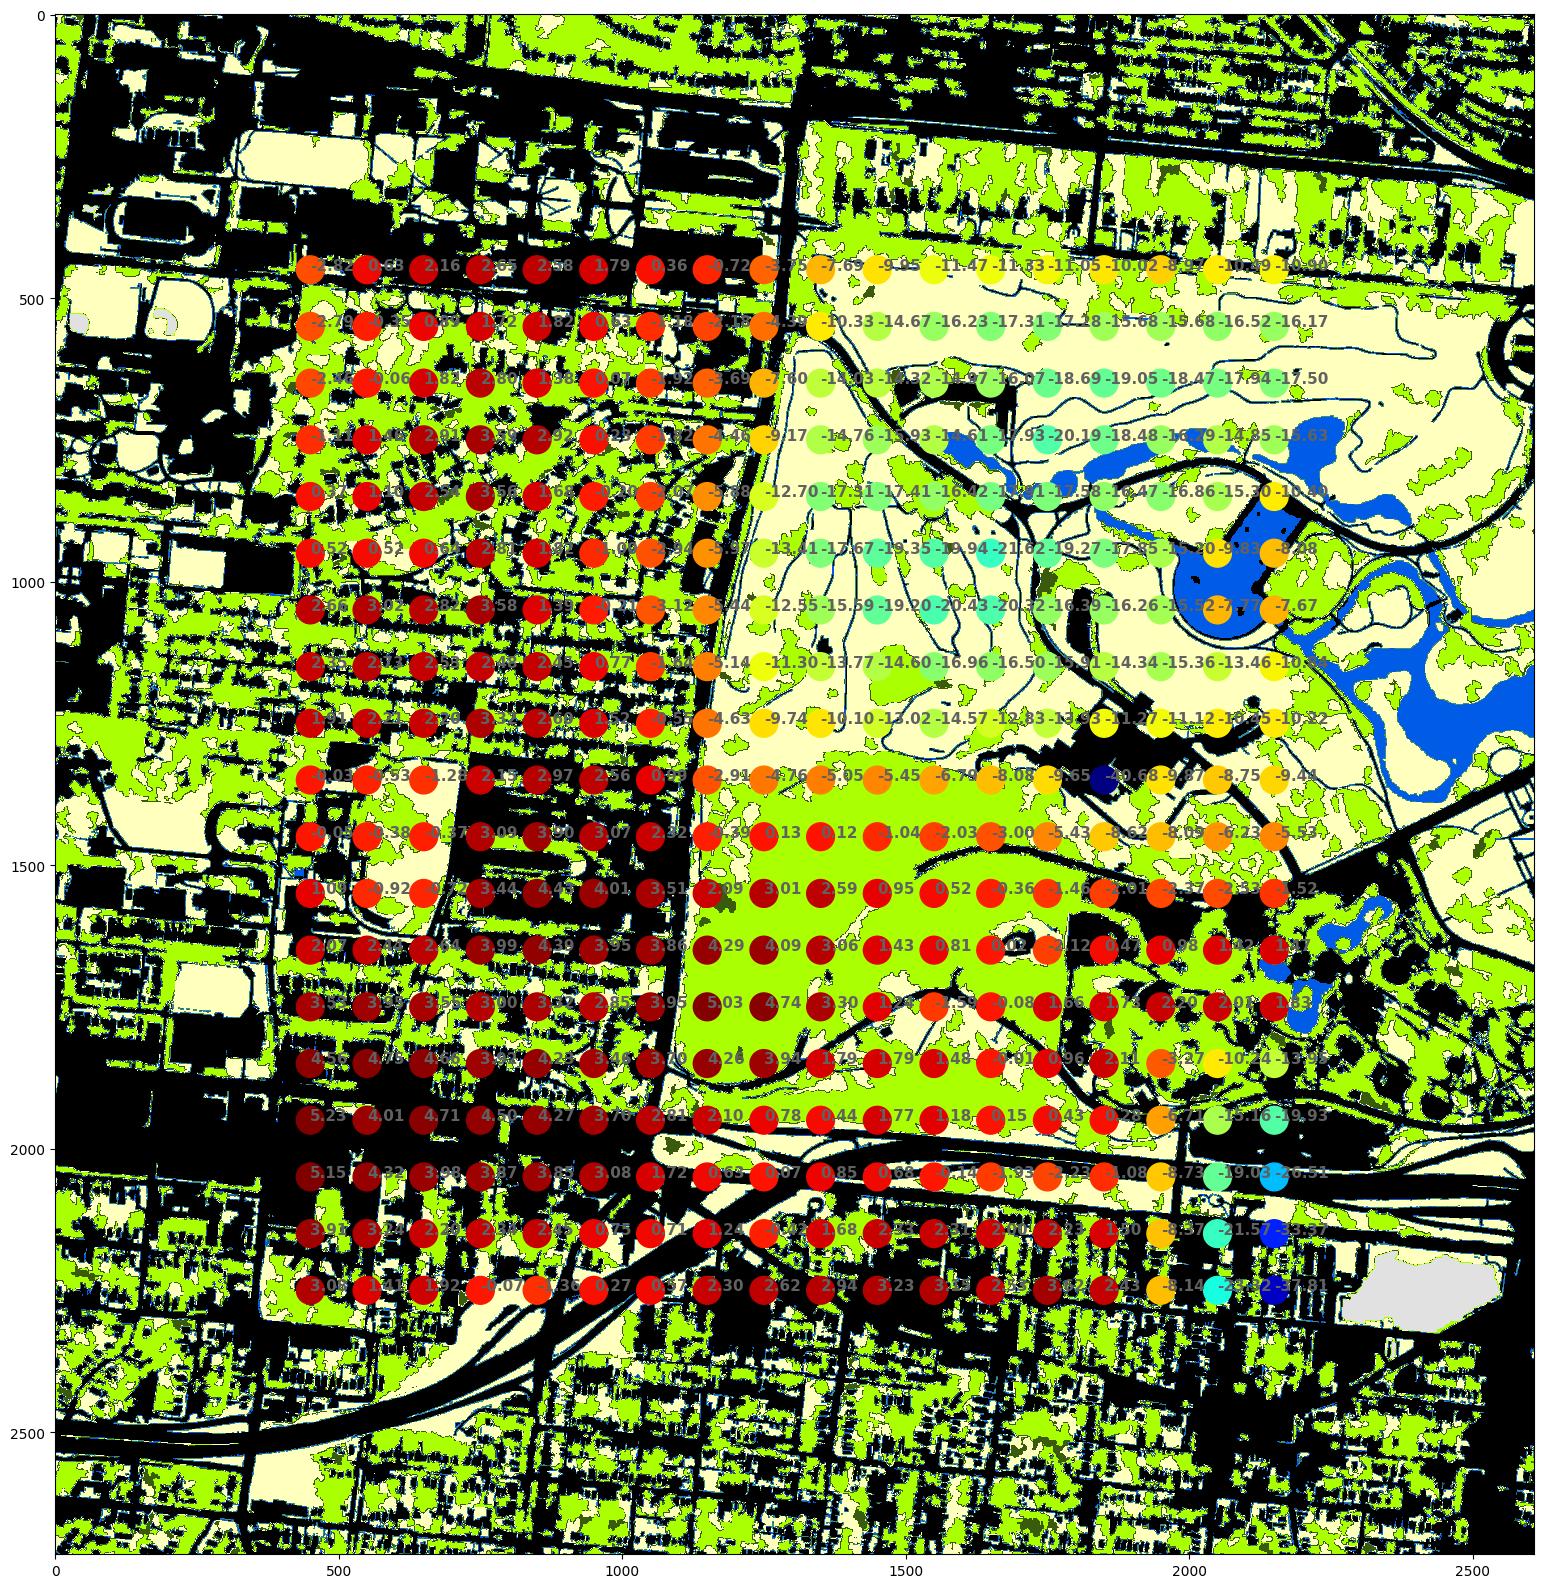

In [93]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(procyon_lotor_prj_vals,cmap=cmap,norm=norm)
ax.scatter(cols,rows,c=kdes,cmap=cm.jet,s=400)
for row,col,txt in predicted_kde:    
    ax.annotate(f'{txt/scale:.2f}', (col, row),fontsize=11,color='#616161',weight='bold')  

#### 2）基于 20m LC 的分析

定义`raster_resampling()`方法，给定栅格单元宽高大小重采样栅格数据，试验中调整栅格为 20m 高空分辨率。后续试验步骤同 1m LC 的分析过程。

In [154]:
LC4procyon_lotor_fn=r'C:\Users\richie\omen_richiebao\omen_data_temp\st_louis_1m.tif'
output_fn=r'C:\Users\richie\omen_richiebao\omen_data_temp\st_louis_20m.tif'
usda_geoprocess_opt.raster_resampling(LC4procyon_lotor_fn,output_fn,20,20)

In [155]:
LC4procyon_lotor_rst=rst.open(output_fn)
procyon_lotor_prj_vals=LC4procyon_lotor_rst.read(1)
row_count,col_count=procyon_lotor_prj_vals.shape

procyon_lotor_prj_fn=r'D:\data_B\movebank\procyon_lotor_prj.gpkg'
procyon_lotor_prj_gdf=gpd.read_file(procyon_lotor_prj_fn)

In [156]:
procyon_lotor_prj_coordinates=np.array([procyon_lotor_prj_gdf.geometry.x,procyon_lotor_prj_gdf.geometry.y]).T
row_col=np.array([LC4procyon_lotor_rst.index(coordi[0],coordi[1]) for coordi in procyon_lotor_prj_coordinates]) # [y(row),x(col)]
print(row_col.shape)

(4865, 2)


将确定距离对运动跟踪轨迹样本点影响的计算过程定义为函数`movements_LCdistSum_model_r2score()`。

In [127]:
LinearRegression_r2score=usda_utils.movements_LCdistSum_model_r2score(range(1,103,3),linear_model.LinearRegression(),procyon_lotor_prj_vals,procyon_lotor_prj_gdf.kde.to_numpy(),row_col)

100%|█████████████████████████████████████████████████| 34/34 [02:59<00:00,  5.27s/it]


从计算结果来看，当距离达到 22 （约为 $22 \times 20 = 440m$）时，开始出现波动，而这个距离与 1m LC 的预测精度稳定时的距离相当。

In [128]:
LinearRegression_r2score

{1: 0.24872895512717164,
 4: 0.3165961742988883,
 7: 0.24727787001854074,
 10: 0.33713099838471616,
 13: 0.4992786626298106,
 16: 0.5865052794824047,
 19: 0.6752945198159627,
 22: 0.7032627593127235,
 25: 0.6962551095341889,
 28: 0.6599360235441081,
 31: 0.6576068948895943,
 34: 0.6046259033982669,
 37: 0.585013355633167,
 40: 0.5967697783908703,
 43: 0.6826675035055636,
 46: 0.7565264183493973,
 49: 0.6693293462930605,
 52: 0.6351276025545508,
 55: 0.7513193969754325,
 58: 0.8163054634421507,
 61: 0.6989120015942778,
 64: 0.5530954096500088,
 67: 0.5604524470705925,
 70: 0.6306560588884627,
 73: 0.5483231694761842,
 76: 0.5435301014919836,
 79: 0.5669327626491885,
 82: 0.5826195106566531,
 85: 0.654000464667081,
 88: 0.6425779447475981,
 91: 0.6775637441894709,
 94: 0.641064474243088,
 97: 0.6371497807128521,
 100: 0.6371362347695113}

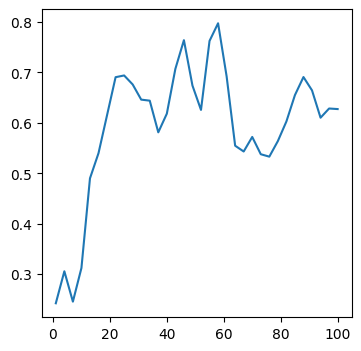

In [129]:
fig, ax=plt.subplots(1, 1,figsize=(4,4))
ax.plot(LinearRegression_r2score_.keys(),LinearRegression_r2score_.values())
plt.show()

选择距离单元数 22（440m）建立预测模型。样本点到邻域 LC 类型单元距离的倒数和计算结果如下。

In [157]:
r=22
group_sum_dict_lst=[]
for row,col in tqdm(row_col):    
    nbr_xy=usda_utils.grid_neighbors(procyon_lotor_prj_vals,row,col,r=r)
    nbr_dist=usda_utils.grid_distance(nbr_xy,row,col)
    group_sum_dict=usda_utils.group_sum(procyon_lotor_prj_vals,nbr_xy,1/nbr_dist)  
    group_sum_dict_lst.append(group_sum_dict)
    
group_sum_df=pd.DataFrame.from_records(group_sum_dict_lst).fillna(0)
group_sum_df.tail(3)

100%|███████████████████████████████████████████| 4865/4865 [00:01<00:00, 2705.61it/s]


,1,2,3,4,5,6,7
4862,19.196726,27.467091,22.167282,30.635614,23.952023,31.197860,0.14086
4863,11.445033,12.382279,13.509043,28.452676,27.574873,61.393550,0.00000
4864,10.712501,12.556948,14.071932,36.369045,28.838497,52.208531,0.00000


预测模型的精度约为 0.701。

In [175]:
X=group_sum_df.to_numpy()
y=procyon_lotor_prj_gdf.kde.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3) 
reg = linear_model.LinearRegression()
reg.fit(X_train,y_train)

y_pred=reg.predict(X_test)
r2_score(y_test, y_pred)

0.709950160384182

In [176]:
procyon_lotor_LinearRegression_450_fn=r'../models/procyon_lotor_LinearRegression_45_20ts20.pickle'
with open(procyon_lotor_LinearRegression_450_fn,'wb') as f:
    pickle.dump(reg,f)

### 3.9.3.3 运动轨迹的预测

为了减小计算量，使用 20m LC 进行试验。其栅格大小为 $135 \times 130$，即有 17550 个状态。

In [150]:
LC4procyon_lotor_fn=r'C:\Users\richie\omen_richiebao\omen_data_temp\st_louis_20m.tif'
LC4procyon_lotor_rst=rst.open(LC4procyon_lotor_fn)
procyon_lotor_prj_vals=LC4procyon_lotor_rst.read(1)
row_num,col_num=procyon_lotor_prj_vals.shape
print(f'{row_num} x {col_num} = {row_num*col_num}')

135 x 130 = 17550


加载 20m LC 栅格数据，和对应 LC 数据距离为 22 个栅格单元已训练的的 KDE 预测模型。并定义包含 LC 分类，起始状态和目标状态的环境地图图例。

In [177]:
procyon_lotor_LinearRegression_450_fn=r'../models/procyon_lotor_LinearRegression_45_20ts20.pickle'
with open(procyon_lotor_LinearRegression_450_fn,'rb') as f:
    reg=pickle.load(f)

LC4procyon_lotor_fn=r'C:\Users\richie\omen_richiebao\omen_data_temp\st_louis_20m.tif'
LC4procyon_lotor_rst=rst.open(LC4procyon_lotor_fn)
procyon_lotor_prj_vals=LC4procyon_lotor_rst.read(1)

levels = list(range(1,10))
clrs = ['#000000','#005ce6', '#3f8f76', '#ffffbe', '#3a5b0d', '#aaff00', '#e1e1e1','#F44336','#eeeee4']    
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, clrs,extend='max')

matplotlib.rcParams['animation.embed_limit'] = 2**128

定义浣熊运动跟踪环境`ProcyonLotorMovementEnv`，配置参数中，`dist` 为栅格单元数表示的距离参数，对应到上述训练的预测模型和所用 LC 栅格数据；`scale`为预测模型返回值（KDE）的缩放系数；`reward_upper_truncation`和`reward_lower_truncation`为用预测模型预测结果的上下界截断，避免预测中出现不合理的值（较大或较小值），及负值；`X_dict`和`X_keys`对应到预测模型解释变量的顺序；`agent_location`和`target_location`为初始状态和目标状态，其目标状态可以为一个区域。

In [189]:
agent_location=[65,65] 
target_location=np.array([[i,j] for i in range(10,40) for j in range(95,95+30)])

procyon_lotor_env=usda_rl.ProcyonLotorMovementEnv(
      procyon_lotor_prj_vals,
      reg,
      agent_location,
      target_location,
      procyon_lotor_prj_vals,
      dist=22,
      scale=20000,
      reward_upper_truncation=10,
      reward_lower_truncation=0,    
      X_dict={1:0,2:0,3:0,4:0,5:0,6:0,7:0},
      X_keys=[1,2,3,4,5,6,7],
      render_mode="rgb_array")

RL 模型使用[Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/index.html)<sup>⑦</sup>库的[PPO](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)<sup>⑫</sup>。

In [190]:
model = PPO("MlpPolicy", procyon_lotor_env, verbose=1,device='cuda')  # tau=0.005
model.learn(total_timesteps=250000,log_interval=4)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


保存训练好的 PPO 模型。

In [191]:
procyon_lotor_env_DQN_fn=r'../models/procyon_lotor_env_PPO_20ts20.sb3'
model.save(procyon_lotor_env_DQN_fn)

In [192]:
model=PPO.load(procyon_lotor_env_DQN_fn)

利用训练的 RL 模型，模拟浣熊从初始位置到目标区域的运动路径。

In [193]:
obs, info = procyon_lotor_env.reset()
frames=[]
states_tabu=[]
for i in tqdm(range(100)):
    frames.append(procyon_lotor_env.render())  
    if obs in states_tabu: 
        action = procyon_lotor_env.action_space.sample()
    else:           
        states_tabu.append(obs)
        action, _states = model.predict(obs, deterministic=True)   
    obs, reward, terminated, truncated, info =procyon_lotor_env.step(action.item())  
        
    if terminated or truncated:
        break

 35%|████████████████▍                              | 35/100 [00:00<00:00, 224.02it/s]


从模拟结果来看，智能体在尽可能获得最大收益情况下运动并到达目标区域，即由 KDE 反应浣熊响应所在环境活动强度的指数作为每步的收益值。该模拟结果一定程度上说明，通过建立 LC 类型和活动强度的预测模型作为 RL 的收益值模拟动物的运动跟踪轨迹是可行的，这为城市生态，生物生境与城市环境关系的探索提供了一种思路。

In [ ]:
figsize_scale=1
dpi=72
fps=60
interval=50

fig=plt.figure(figsize=(10,10))
patch = plt.imshow(frames[0],cmap=cmap,norm=norm) 
plt.axis('off')
def animate(i):
    patch.set_data(frames[i]) 

anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=interval)
anim.save(filename="../graph/movebank.gif", writer="pillow")
HTML(anim.to_jshtml())

<img src="../imgs/3_9_b/movebank.gif" height='auto' width='auto' title="caDesign">

---

注释（Notes）：

①  Gymnasium （Gym）库，（<https://gymnasium.farama.org/content/basic_usage/>）。

②  OpenAI，（<https://openai.com/>）。

③  Colaborator，CoLab，（<https://colab.research.google.com/>）。

④  Frozenlake benchmark，（<https://gymnasium.farama.org/tutorials/training_agents/FrozenLake_tuto/>）。

⑤  Make your own custom environment，（<https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/>）。

⑥  torch.nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)，（<https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html>）。

⑦  Stable Baselines3 (SB3)，（<https://stable-baselines3.readthedocs.io/en/master/index.html>）。

⑧  Movebank，（<https://www.movebank.org/cms/movebank-main>）。

⑨  森林公园生活实验室（Forest Park Living Lab，FPL），（<https://www.movebank.org/cms/webapp?gwt_fragment=page=studies,path=study1605024900>）。

⑩  ESA WorldCover 2021，（<https://worldcover2021.esa.int/downloader>）。

⑪  St. Louis Regional Data Exchange，（<https://rdx.stldata.org/dataset/land-cover/resource/8f5def62-3da3-436a-be63-e277ce33d2ed>）。

⑫  PPO，（<https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html>）。

参考文献（References）:

[1] Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., … Hassabis, D. (2015). Human-level control through deep reinforcement learning. Nature, 518(7540), 529–533. doi:10.1038/nature14236

[2] Reinforcement Learning(DQN) tutorial, <https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html>

[3] Millington, Andrew C.; Walsh, Stephen J.; & Osborne, Patrick E. (2001). GIS and Remote Sensing Applications in Biogeography and Ecology. Boston: Kluwer Academic Publishers.

[4] Okubo A. Diffusion and Ecological Problems: Mathematical Models. Berlin: Springer- Verlag, 1980.

[5] Berg He. Random walks in biology. Princeton, NJ: Princeton University Press, 1983.

[6] McCullouch CE, Cain ML. Analyzing discrete movement data as a correlated random walk. Ecology 1989; 70: 383-388.

[7] Hyman JB, McAninch JB, DeAngelis DL. 1991. "An individual-based model of herbivory in a heterogeneous landscape." In Quantitative Methods in lAndscape Ecology, MG Turner, RH Gardner eds. Heidelberg: Springer-Verlag, 1991.

[8] Turner MG, Wu Y, Romme WH, Wallace LL. A landscape simulation model of winter foraging by large ungulates. Ecological Modeling 1993; 69: 163-184.

[9] Webster, S., Beasley, J., Hinton, J., & Chamberlain, M. (2022). Resident and transient coyotes exhibit differential patterns of movement behavior across heterogeneous landscapes in the southeastern United States. Ecology and Evolution, 12.

[10] Butts, D., Thompson, N., Christensen, S., Williams, D., & Murillo, M. (2022). Data-driven agent-based model building for animal movement through Exploratory Data Analysis. Ecological Modelling, 470, 110001.